In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.metrics import structural_similarity as ssim

In [6]:
def get_ssim(image1_path,image2_path):
    
    image_gray1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
    image_gray2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale

    image_gray1 = cv2.resize(image_gray1,(256,256))
    image_gray2 = cv2.resize(image_gray2,(256,256))

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    clahe_image1 = clahe.apply(image_gray1)
    clahe_image2 = clahe.apply(image_gray2)

    lwr = np.array([240])
    upp = np.array([255])
    image_mask1 = cv2.inRange(clahe_image1, lwr, upp)
    image_mask2 = cv2.inRange(clahe_image2, lwr, upp)
    pixel_count_img1 = cv2.countNonZero(image_mask1)
    pixel_count_img2 = cv2.countNonZero(image_mask2)
    print("pixel bianchi di ", image1_path, ": ",pixel_count_img1)
    print("pixel bianchi di ", image2_path, ": ",pixel_count_img2)
    print("diff: ",(pixel_count_img1-pixel_count_img2))

    return ssim(image_mask1, image_mask2, full=True)

In [7]:
def process_and_display_image(image_path):
    ddepth = cv2.CV_16S
    kernel_size = 3
    
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
    image = cv2.resize(image, (256,256))

    ###############################################################################################CLAHE
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    clahe_image = clahe.apply(image)
    ###############################################################################################CLAHE

    blurred = cv2.GaussianBlur(clahe_image, (7,7), 0)  # Apply Gaussian Blur
    laplacian = cv2.Laplacian(blurred, ddepth, ksize=kernel_size)  # Apply Laplacian filter
    abs_laplacian = cv2.convertScaleAbs(laplacian)

    ###################
    threshold = cv2.threshold(abs_laplacian, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    #adapt_threshold = cv2.adaptiveThreshold(abs_laplacian,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)

    # Dilation
    kernel = np.ones((5,5), np.uint8)
    dilate = cv2.dilate(threshold, kernel, iterations=2)
    ##################

    lwr = np.array([240])
    upp = np.array([255])
    image_mask = cv2.inRange(clahe_image, lwr, upp)


    # Display images
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Original")
    axes[0].axis("off")
    
    axes[1].imshow(blurred, cmap='gray')
    axes[1].set_title("Gaussian Blur")
    axes[1].axis("off")
    
    axes[2].imshow(abs_laplacian, cmap='gray')
    axes[2].set_title("Laplacian")
    axes[2].axis("off")

    axes[3].imshow(image_mask, cmap='gray')
    axes[3].set_title("adapt_threshold")
    axes[3].axis("off")
    
    plt.suptitle(os.path.basename(image_path))
    plt.show()
    
    return image_mask

def process_images_from_folder(folder_path):
    if not os.path.exists(folder_path):
        print("Error: Specified folder does not exist.")
        return
    
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg', 'webp', 'tiff'))]
    if not image_files:
        print("No images found in the folder.")
        return
    
    histograms_list = []
    
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        processed_image = process_and_display_image(image_path)  # Process and display image
        hist = cv2.calcHist([processed_image], [0], None, [256], [0, 256])
        #hist = cv2.equalizeHist(hist) #TODO 
        histograms_list.append((image_file, hist))
    
    distance_matrix = pd.DataFrame(0, index=image_files, columns=image_files, dtype='float64')
    
    # Calculate histogram distances
    for i in range(len(histograms_list)):
        for j in range(i, len(histograms_list)):
            image1, hist1 = histograms_list[i]
            image2, hist2 = histograms_list[j]
            
            total_distance = 10 * cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)  # Compute distance
            distance_matrix.loc[image1, image2] = total_distance
            distance_matrix.loc[image2, image1] = total_distance

            if(image1 != image2):
                ssim_score = get_ssim(os.path.join(folder_path, image1), os.path.join(folder_path, image2))
                print("SSIM: ",image1," ",image2," = "  ,round(ssim_score[0], 2))

    distance_matrix.to_csv(os.path.join(folder_path, "distance_matrix.csv"))

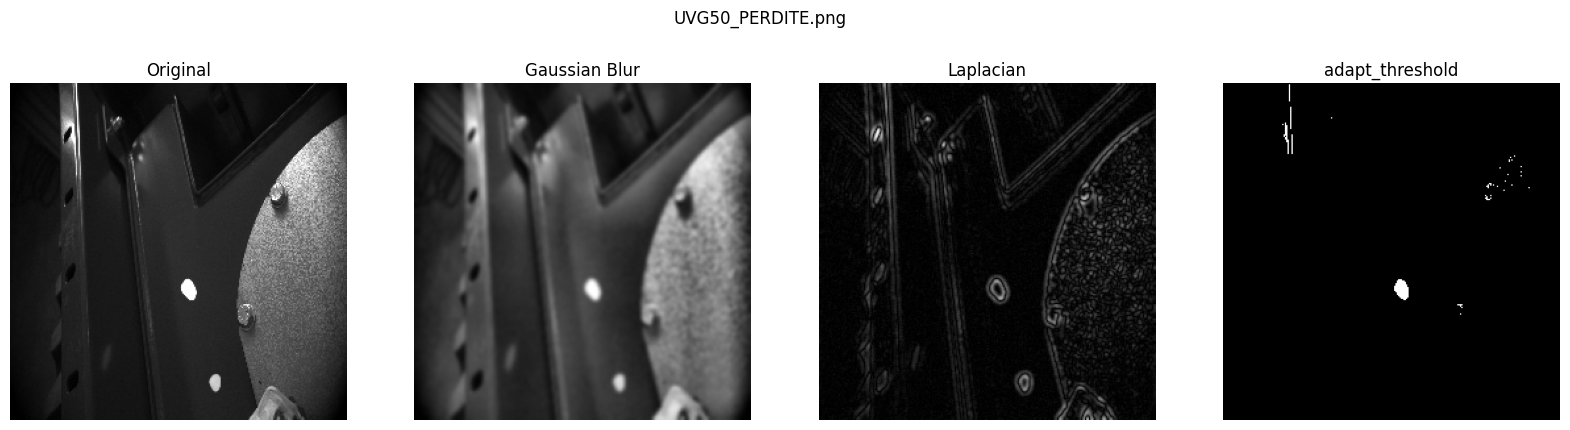

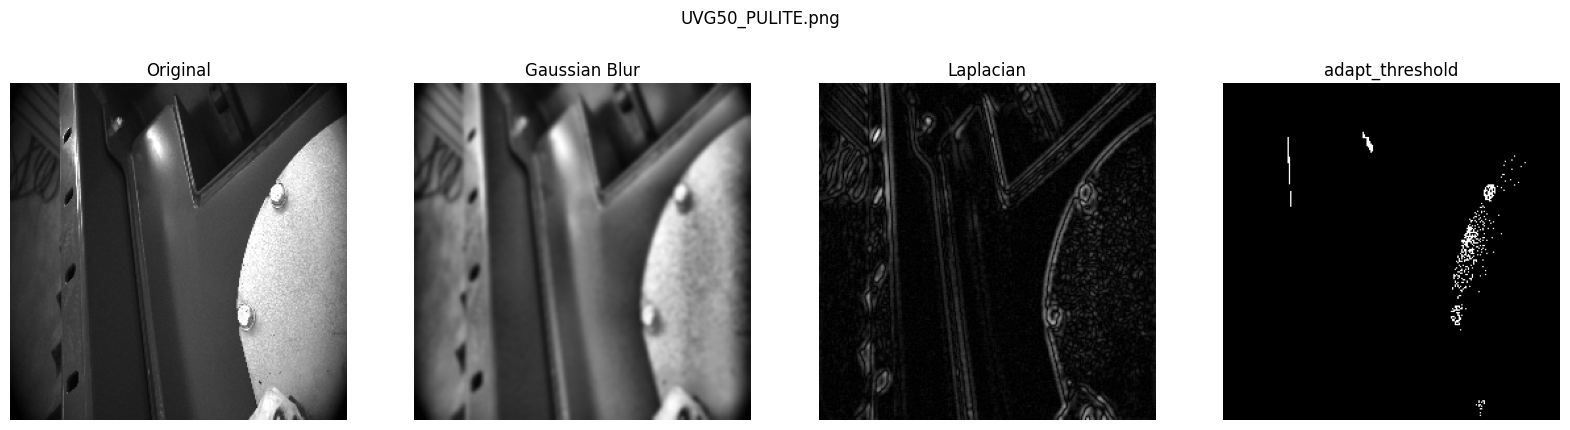

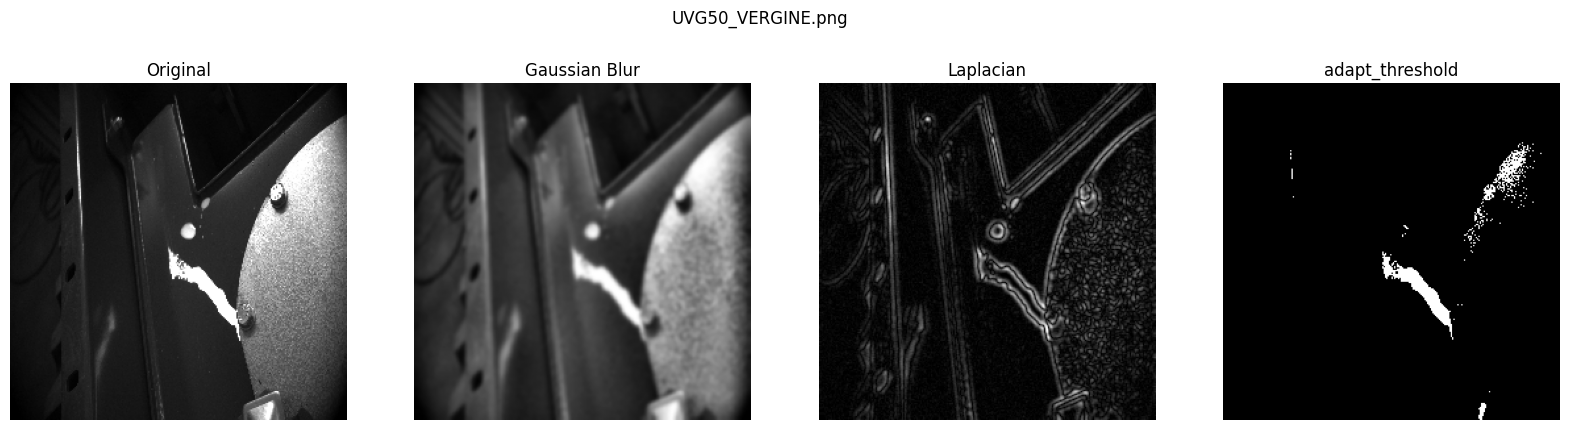

pixel bianchi di  datasetSuddiviso/UVG50/UVG50_PERDITE.png :  489
pixel bianchi di  datasetSuddiviso/UVG50/UVG50_PULITE.png :  1268
diff:  -779
SSIM:  UVG50_PERDITE.png   UVG50_PULITE.png  =  0.88
pixel bianchi di  datasetSuddiviso/UVG50/UVG50_PERDITE.png :  489
pixel bianchi di  datasetSuddiviso/UVG50/UVG50_VERGINE.png :  1762
diff:  -1273
SSIM:  UVG50_PERDITE.png   UVG50_VERGINE.png  =  0.87
pixel bianchi di  datasetSuddiviso/UVG50/UVG50_PULITE.png :  1268
pixel bianchi di  datasetSuddiviso/UVG50/UVG50_VERGINE.png :  1762
diff:  -494
SSIM:  UVG50_PULITE.png   UVG50_VERGINE.png  =  0.86


In [8]:
folder_path = "datasetSuddiviso/UVG50"
process_images_from_folder(folder_path)